# Mushroom Detection Model - Test and Implementation

## Import Basic Libraries

In [31]:
# import default libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import torch

In [32]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.17  Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 16384MiB)
Setup complete  (16 CPUs, 31.7 GB RAM, 535.7/931.0 GB disk)


In [33]:
from ultralytics import YOLO

## Variables and Functions to Access Test Data and Show Results

The variables beneath to access the directories with the untouched test data that is seperate from the validation and training sets used in the training notebooks as well as a dictionary for the classes of the dataset. The functions following the variable declaration are either to randomize the samples when doing batch predictions for testing, and to get the labels from the test set for those predictions. The testing predictions seen in this notebook are done on the test set of data (ones seperate from validation and training that have already been seen by the model) as there is a labeled ground truth to compare the model's accuracy with. 

In [34]:
# paths to images in two different formats to be used depending on what the function needs, dir for those that need glob.glob to iterate through files
test_image_dir = 'mushroom-data/test/images/*'
test_label_dir = 'mushroom-data/test/labels/*'
# these paths are used to concatonate with other strings to get files 
test_image_path = 'mushroom-data/test/images'
test_label_path= 'mushroom-data/test/labels'

In [35]:
# Dictionary of classes of the data set in order to use to interpret the labels in of the test data and get the ground truth 
mush_class_dict = {'0': 'Amanita citrina', 
              '1': 'Amanita hemibapha', 
              '2': 'Amanita javanica', 
              '3': 'Amanita pantherina', 
              '4': 'Amanita princeps', 
              '5': 'Boletus reticulatus', 
              '6':'Coltricia perennis', 
              '7': 'Gyromitra infula', 
              '8':'Hygrophoropsis aurantiaca', 
              '9': 'Imleria badia', 
              '10': 'Lactarius turpis', 
              '11': 'Russula emetica', 
              '12': 'Suillus grevillei', 
              '13': 'Suillus luteus'}

In [36]:
# Function that gets an label text file from an predicted image, assuming image root file name does not change in prediction process.
def get_ground_truth(image_path, label_dir, class_dict):
    # takes image path, gets root name and iterates through the files of another directory to get text file
    root_name = os.path.basename(image_path).removesuffix('.jpg')
    mush_instances = []
    mush_instance_names = []
    for item in glob.glob(label_dir):
        txt_file = os.path.basename(item)
        if root_name in txt_file:
            # Once file is found, each class will be discerened from each line in the text file. 
            file_location = label_dir.strip('*') + '/' + txt_file
            file_data = open(file_location, "r")
            for line in file_data:
                line.split()
                data = line.split(' ')
                mush_class = data[0]
                # Classes are saved in a list 
                mush_instances.append(mush_class)
    # As classes are represented as indexes in the file, they will use the dictionary to interpret the full name rather than just the number
    for mush in mush_instances:
        instance_class = class_dict[mush]
        mush_instance_names.append(instance_class)
    return mush_instance_names
        

In [37]:
# Function to get a random sample of paths from a directory
import os, glob, random
def randomized_sample(raw_path, sample_size):
    path_list = []
    for i in range(sample_size):
        file = raw_path + '/' + random.choice(os.listdir(raw_path))
        path_list.append(file)
    return path_list

In [38]:
# Function to find the same file from one directory in another (used for comparison between predictions of small and tiny model)
def get_similar_file(original_file_path, new_file_path):
    root_name = os.path.basename(original_file_path)
    for item in glob.glob(new_file_path + '/*'):
        if root_name in item:
            new_file_path = new_file_path + '/' + root_name
            return new_file_path
    

## Make Predictions 

Here, to make predictions, this code will grab a list of paths from the test sets images and feed it through both models seperately. At the end both prediction folders should have gone through the same images to predict enabling the comparison between each model. 

In [16]:
#get randomized sample from test data
mushroom_test_sample = randomized_sample(test_image_path, 20)

### Loading Small Mushroom Model for Predictions

In [130]:
# loading small model
mush_model_small = YOLO('models/mushroom_model_small.pt')
mush_model_small.to('cuda')

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [134]:
# use small model for predictions 
for path in mushroom_test_sample:
    mush_model_small(path, save=True, exist_ok = True, name='predict')


image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\28075medium_jpeg.rf.1d8b2ea2b98583647a86f73a2b172118.jpg: 480x640 2 Suillus grevilleis, 44.8ms
Speed: 3.4ms preprocess, 44.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\28170medium_jpeg.rf.a8a2c9dcfe5b73ec43af657c922ec571.jpg: 640x480 1 Imleria badia, 1 Suillus grevillei, 1 Suillus luteus, 44.2ms
Speed: 3.5ms preprocess, 44.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\AP149_jpg.rf.29cc2b6dc27ab610b14e7aba10718964.jpg: 416x640 1 Amanita princeps, 35.6ms
Speed: 2.7ms prep

### Loading Tiny Mushroom Model for Predictions

While training the small model, it occurred to the team that for a mobile application, the small model of YOLO would be too big. As such a tiny version of YOLO was trained as well to create one that can be used in a mobile device app, as it's model is much smaller in size. Adjustments to the training of the tiny version can be seen in the training notebook. 

In [132]:
# loading tiny model
mush_model_tiny = YOLO('models/mushroom_model_tiny.pt')
mush_model_tiny.to('cuda')

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [133]:
# use tiny model for predictions 
for path in mushroom_test_sample:
    mush_model_tiny(path, save=True, exist_ok = True, name='predict2')


image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\28075medium_jpeg.rf.1d8b2ea2b98583647a86f73a2b172118.jpg: 480x640 1 Imleria badia, 1 Suillus grevillei, 18.7ms
Speed: 3.6ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict2

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\28170medium_jpeg.rf.a8a2c9dcfe5b73ec43af657c922ec571.jpg: 640x480 1 Imleria badia, 17.6ms
Speed: 4.0ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict2

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\AP149_jpg.rf.29cc2b6dc27ab610b14e7aba10718964.jpg: 416x640 1 Amanita princeps, 16.7ms
Speed: 3.0ms preprocess, 16.7ms infere

## Show Test Results 

This section is dedicated to showing the results of the generated tests from above. The code must be run sequentially as the second requires the selection of the first to view the correct image for comparison between the small and tiny models. The ground truth of the labels are also available to see the accuracy of the models. 

Image Ground Truth Lables: ['Lactarius turpis']


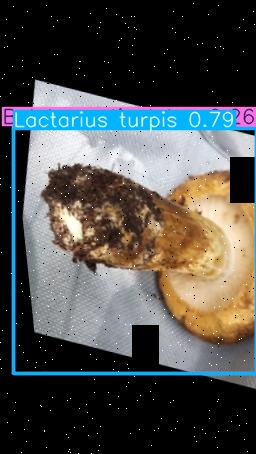

In [41]:
# Show Image stored for small model model 
%matplotlib inline
from PIL import Image
import random, os

# select image in the from the predict folder and save the name to find the equivalent in the tiny-model prediction folder
smallmodel_filepath = 'runs/detect/predict'
image_select = random.choice(os.listdir('runs/detect/predict'))
img_path= 'runs/detect/predict/' + image_select
ground_truth = get_ground_truth(img_path, test_label_dir, mush_class_dict)
print(f'Image Ground Truth Lables: {ground_truth}')
Image.open(img_path)

Image Ground Truth Lables: ['Lactarius turpis']


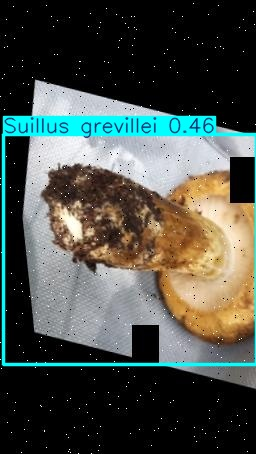

In [42]:
# Show Image stored for tiny model 
%matplotlib inline
img2_path = get_similar_file(img_path, 'runs/detect/predict2')
print(f'Image Ground Truth Lables: {ground_truth}')
Image.open(img2_path)